In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

# plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# def generate_population(communities, size):
#     population = communities * size

#     agents = [
#         TabularQLearner(lookback=1, epsilon=0.1, learning_rate=0.05)
#         for i in range(population)
#     ]

#     G = nx.connected_caveman_graph(communities, size)

#     weights_matrix = np.zeros((population, population))
#     for u, v, d in G.edges(data=True):
#         weights_matrix[u, v] = weights_matrix[v, u] = 1
#         try:
#             d["weight"] = weights_matrix[u, v]
#         except:
#             d["weight"] = 0

#     return agents, weights_matrix, G

In [3]:
def generate_population(communities, size):
    population = communities * size

    agents = [
        DoubleTabularQLearner(
            lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.98
        )
        for i in range(population)
    ]

    # G = nx.connected_caveman_graph(communities, size)

    G = nx.Graph()
    G.add_weighted_edges_from([(0, i, 1) for i in range(1, population)])

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [4]:
# _, _, G = generate_population(2, 16)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [5]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1) if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None
        else "OTHER"
        for policy in policies
    ]


def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [6]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/30000 [00:00<?, ?it/s]

BEST AGENT (0): 28303008 (0.287346875, DDCDDDCDDDDDDDCC)
WORST AGENT (131): 24351 (0.9335636460271061, CCCDCDCCCCCCCCCC)


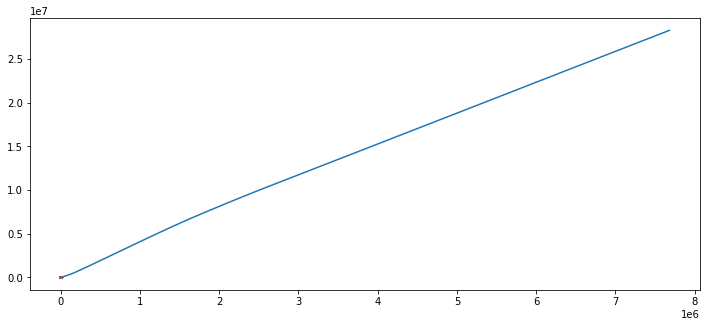

In [7]:
POPULATION = (64, 4)
ROUNDS = 30_000

run_rewards = []
run_cumulative_rewards = []
# run_action_histories = []
run_reward_histories = []
run_policies = []

for run in range(1):
    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        sim.play_round(train=True)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))

    plt.show()

In [8]:
# plot_matrix(sim.produce_weight_matrix(), digits=2, figsize=(60, 36))

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
sim.calculate_weights()

[array([0.05      , 0.0719714 , 0.05      , 0.05      , 0.0747709 ,
        0.07029532, 0.07098128, 0.05      , 0.07013076, 0.05      ,
        0.07299949, 0.05      , 0.05      , 0.07126117, 0.05      ,
        0.07274064, 0.05      , 0.05      , 0.07871861, 0.07402158,
        0.07725477, 0.07488315, 0.05      , 0.07619337, 0.05      ,
        0.07617439, 0.07130491, 0.05      , 0.06057337, 0.07612325,
        0.07263927, 0.07334995, 0.0737757 , 0.06957067, 0.05103262,
        0.07382157, 0.07463225, 0.07442626, 0.07321884, 0.05      ,
        0.07697932, 0.07073957, 0.06188673, 0.07275513, 0.05955364,
        0.06471593, 0.07296693, 0.05417524, 0.05      , 0.05      ,
        0.05      , 0.07533312, 0.07314403, 0.07312076, 0.0741991 ,
        0.07274324, 0.07454826, 0.07188371, 0.05121187, 0.05      ,
        0.07226327, 0.07428315, 0.07946317, 0.05      , 0.07388726,
        0.05      , 0.07538496, 0.05      , 0.05      , 0.0732829 ,
        0.05      , 0.07429618, 0.05141433, 0.05

In [11]:
sim.action_histories[0][2]

[<Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>

In [12]:
cumulative_rewards[0][0]

0

In [13]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[356.81348628 359.75637707]
  [356.70934736 358.36691609]
  [358.26737122 356.59988188]
  [356.90369627 359.54558886]]

 [[356.61122355 359.54498294]
  [356.33046053 357.63301587]
  [357.34449548 356.20110519]
  [356.06165032 359.23418308]]

 [[357.39978758 360.46683634]
  [357.15227192 359.67159263]
  [351.85374    354.28001707]
  [356.9880893  359.77453235]]

 [[356.77962051 360.41023082]
  [357.43649057 359.48754094]
  [358.16383048 356.33319176]
  [358.06379717 355.82941888]]]


In [14]:
agents[cumulative_rewards[4][0]].play_move(
    [Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE]
)

<Action.COOPERATE: 0>

In [15]:
agents[1]._q_table

array([[[ 89.77784141,  11.97801003],
        [ 93.57401398, 107.69386037],
        [ 56.54810082,   7.17341969],
        [ 98.74641549,  49.14142182]],

       [[104.35280173,  82.42128913],
        [ 55.33177204,  92.14987954],
        [101.66046761,  67.09750877],
        [ 67.40342207,  94.58253728]],

       [[ 92.61267299,  20.24277529],
        [104.68005803,  90.43564235],
        [ 25.00515549,   1.98633962],
        [ 85.54663379,  16.99645495]],

       [[ 45.24493387,  92.98917483],
        [104.76500777,  77.15932667],
        [ 75.432381  ,  10.5988038 ],
        [ 97.07535492,  57.50384599]]])

In [16]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)

In [17]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {
    policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()
}
mean_cumulative_reward_policies = {
    policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()
}

In [18]:
for policy in sorted(
    mean_cumulative_reward_policy_ranks,
    key=lambda x: mean_cumulative_reward_policy_ranks[x],
):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

1.0                      DDCDDDCDDDDDDDCC
2.0                      CDCCCDCDCCCCCCCD
3.0                      DDCCCDCCCDCCCDCC
4.0                      DDCCCDCCCDCCDCCC
5.0                      CDCCCDCDCCCCCCCC
6.0                      CDCDCDCDCCCCCCCC
7.0                      CDDCCDCCCDCCCCCC
8.0                      CDCCCDCCCDCCCCCC
9.0                      CDCCCDCDCCCCDCCC
10.0                     CCCDCDCDDCCCCCCD
11.0                     CDCCCDDCCCDCCDCC
13.0                     CDCCCDDCCCDCDCCC
14.5                     CDCCCDCCCCCCCDCC
16.0                     DCCCDDCCDCCCDDCC
17.0                     CDCCDDCCCDCCCDCC
18.0                     CCCCDDDCCCCDCDCC
19.0                     CCCCCDCDCCCDCCCD
20.0                     CCCCCDCDCCCCCCCD
20.0                     CDCCCDDCCCCCCCCC
21.0                     CCCDCDCDCCCCCCCD
22.0                     DCCCCDDCCCCDCDCC
24.666666666666668       CDCCCDCCDCCCCCCC
25.0                     CDCDCDCCCCCDCCCC
26.0                     CDCCCDCCC

In [19]:
for policy in sorted(
    mean_cumulative_reward_policies,
    key=lambda x: mean_cumulative_reward_policies[x],
    reverse=True,
):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

28303008.0               DDCDDDCDDDDDDDCC
48971.0                  CDCCCDCDCCCCCCCD
46441.0                  DDCCCDCCCDCCCDCC
45242.0                  DDCCCDCCCDCCDCCC
45032.0                  CDCCCDCDCCCCCCCC
44826.0                  CDCDCDCDCCCCCCCC
44646.0                  CDDCCDCCCDCCCCCC
44631.0                  CDCCCDCCCDCCCCCC
43594.0                  CDCCCDCDCCCCDCCC
43586.0                  CCCDCDCDDCCCCCCD
43384.0                  CDCCCDDCCCDCCDCC
42568.0                  CDCCCDDCCCDCDCCC
42258.0                  CDCCCDCCCCCCCDCC
42169.0                  DCCCDDCCDCCCDDCC
42004.0                  CDCCDDCCCDCCCDCC
41774.0                  CCCCDDDCCCCDCDCC
41292.0                  CCCCCDCDCCCCCCCD
40181.0                  CCCCCDCDCCCDCCCD
40055.0                  CDCCCDDCCCCCCCCC
40055.0                  CCCDCDCDCCCCCCCD
39927.0                  DCCCCDDCCCCDCDCC
39588.333333333336       CDCCCDCCDCCCCCCC
39525.0                  CDCDCDCCCCCDCCCC
39512.0                  CDCCCDCCC

In [20]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'DDCDDDCDDDDDDDCC'

In [21]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[356.81348628 359.75637707]
  [356.70934736 358.36691609]
  [358.26737122 356.59988188]
  [356.90369627 359.54558886]]

 [[356.61122355 359.54498294]
  [356.33046053 357.63301587]
  [357.34449548 356.20110519]
  [356.06165032 359.23418308]]

 [[357.39978758 360.46683634]
  [357.15227192 359.67159263]
  [351.85374    354.28001707]
  [356.9880893  359.77453235]]

 [[356.77962051 360.41023082]
  [357.43649057 359.48754094]
  [358.16383048 356.33319176]
  [358.06379717 355.82941888]]]


In [22]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => D
('(C, C)', '(C, D)') => D
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => D
('(C, D)', '(C, C)') => D
('(C, D)', '(C, D)') => D
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => D
('(D, C)', '(C, C)') => D
('(D, C)', '(C, D)') => D
('(D, C)', '(D, C)') => D
('(D, C)', '(D, D)') => D
('(D, D)', '(C, C)') => D
('(D, D)', '(C, D)') => D
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
